# Quiz 1

# Intro

Pada kuis ini, Anda diminta untuk melakukan klasifikasi citra wajah dengan menggunakan dataset Labeled Face in Wild (LFW).
Spesifikasi pengerjaan kuis yang harus dipehuni adalah,

1. Setiap label dari dataset LFW harus berisikan minimal 10 gambar (5 poin) - **DONE**
2. Citra yang digunakan merupakan citra RGB / color (5 poin) - **DONE**
3. (Opsional) Lakukan proses pra pengolahan data jika diperlukan (ekstra 10 poin) - **DONE**
4. (Wajib) Gunakan fitur histogram untuk setiap channel citra (35 poin) - **DONE**
5. (Wajib) Gunakan algoritma SVM sebagai model dasar (35 poin) - **DONE**
6. (Wajib) Gunakan metric akurasi, dan *classification report* untuk melihat performa model (20 poin) - **DONE**

## Challenge
Setelah menyelesaikan kuis berdasarkan spesifikasi wajib, Anda diperkenankan untuk

- Menggunakan fitur lain selain histogram (ekstra 20 poin) - **DONE** | ORB
- Menggunakan model lain selain SVM (ekstra 10 poin) - **DONE** | Random Forest & XGBoost
- Evalusi dengan metric lain ataupun report dengan *confusion matrix* (ekstra 10 poin) - **DONE** | f1 Score

# KELOMPOK PALING ANU - 5
1. Cinthya Achwatul Ifnu    (2241720051)
2. Doni Wahyu Kurniawan			(2241720015)
3. Halur Muhammad Abiyyu		(2141720072)
4. Muhammad Iqbal Makmur		(2241720099)

## Preparation

In [1]:
# Load required library
# Import Required Library
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.svm import SVC
from skimage.feature import hog
from scipy.stats import randint, uniform 
from skimage.color import rgb2gray 
from sklearn.datasets import fetch_lfw_people
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

## Load Data

In [2]:
# Load Dataset
# We will load dataset only for faces with contain min 10 images
# We also want to keep images in color; color=True
faces = fetch_lfw_people(min_faces_per_person=100, color=True)

# Check Faces
print(f'Total Label: {len(faces.target_names)}')
print(f'Data dimension: {faces.images.shape}')
print(f'Images flatten dimension: {faces.data.shape}')

Total Label: 5
Data dimension: (1140, 62, 47, 3)
Images flatten dimension: (1140, 8742)


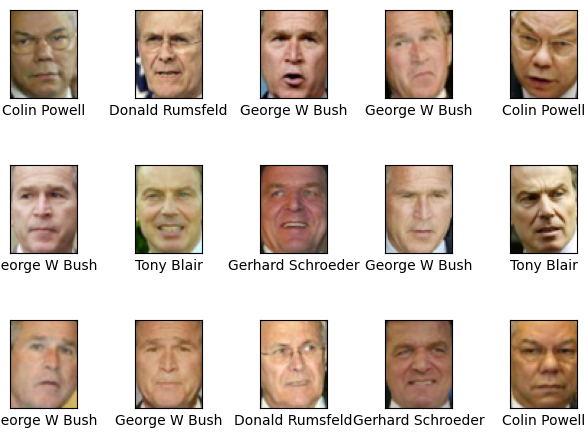

In [3]:
# Check by Plotted Images
# Generate random 15 images
rand_labels = [np.random.randint(0, len(faces.data)) for x in range(0,15)]

fig, ax = plt.subplots(3, 5)
fig.tight_layout()
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[rand_labels[i]], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[rand_labels[i]]])

## Preprocessing

In [4]:
def preprocess_images(images, size=(64, 64)):
    processed_images = []
    for image in images:
        # Resize image to specified dimensions
        resized_image = cv2.resize(image, size)
        # Apply histogram equalization to each channel
        for i in range(3):  # RGB channels
            resized_image[..., i] = cv2.equalizeHist((resized_image[..., i] * 255).astype(np.uint8))
        # Normalize pixel values to [0, 1]
        resized_image = resized_image / 255.0
        processed_images.append(resized_image)
    return np.array(processed_images)

# Preprocess the images
faces_images_processed = preprocess_images(faces.images, size=(64, 64))

## Features Extraction

In [5]:
# Function to Extract Histogram Features for Each Channel
def generate_hist(data, bins_num=100):
    hist_data = []
    for image in data:
        hist_red = np.histogram(image[..., 0].ravel(), bins=bins_num)[0]
        hist_green = np.histogram(image[..., 1].ravel(), bins=bins_num)[0]
        hist_blue = np.histogram(image[..., 2].ravel(), bins=bins_num)[0]
        hist_data.append(np.concatenate((hist_red, hist_green, hist_blue)))
    return np.array(hist_data)

In [6]:
# Extract histogram features
hist_features = generate_hist(faces_images_processed, bins_num=100)
print(f'Extracted Histogram Features Shape: {hist_features.shape}')

Extracted Histogram Features Shape: (1140, 300)


## Build Model

In [7]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(hist_features, faces.target,
                                                    test_size=0.3, random_state=42,
                                                    stratify=faces.target)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM Model with Grid Search for Hyperparameter Tuning
svm_model = SVC()
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],  # Relevant for 'poly' kernel
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(svm_model, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.1s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.1s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.2s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.2s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.2s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=poly; total time=   0.1s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END C=0.1, class_weight=N

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'class_weight': [None, 'balanced'],
                         'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=2)

In [8]:
# Best Model from Grid Search
best_model = grid_search.best_estimator_

## Evaluation

In [9]:
# Confusion Matrix Visualization
def plot_confusion_matrix(y_true, y_pred, target_names):
    mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

Accuracy on Train: 100.00%
Accuracy on Test: 45.32%
                   precision    recall  f1-score   support

     Colin Powell       0.36      0.06      0.10        71
  Donald Rumsfeld       0.00      0.00      0.00        36
    George W Bush       0.46      0.94      0.62       159
Gerhard Schroeder       0.00      0.00      0.00        33
       Tony Blair       0.33      0.02      0.04        43

         accuracy                           0.45       342
        macro avg       0.23      0.20      0.15       342
     weighted avg       0.33      0.45      0.32       342



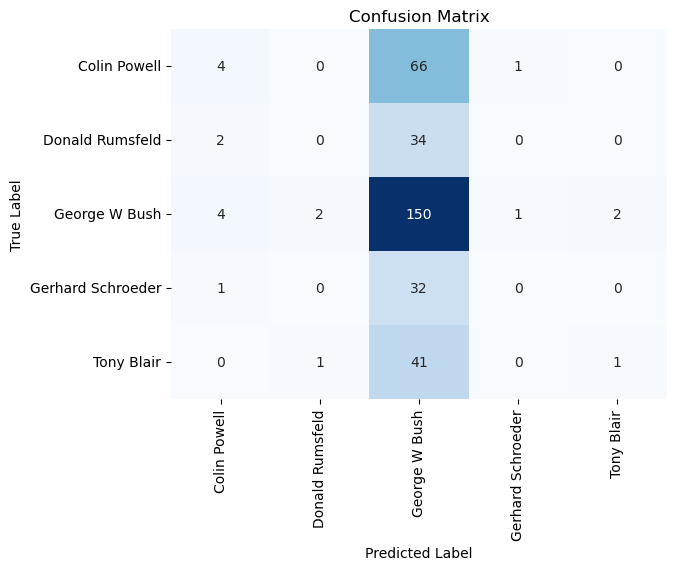

In [10]:
# Evaluation
y_train_predict = best_model.predict(X_train)
y_test_predict = best_model.predict(X_test)

# Print Accuracy
print(f'Accuracy on Train: {accuracy_score(y_train, y_train_predict):.2%}')
print(f'Accuracy on Test: {accuracy_score(y_test, y_test_predict):.2%}')
print(classification_report(y_test, y_test_predict, target_names=faces.target_names))

# Plot confusion matrix
plot_confusion_matrix(y_test, y_test_predict, faces.target_names)

Text(113.92222222222219, 0.5, 'predicted label')

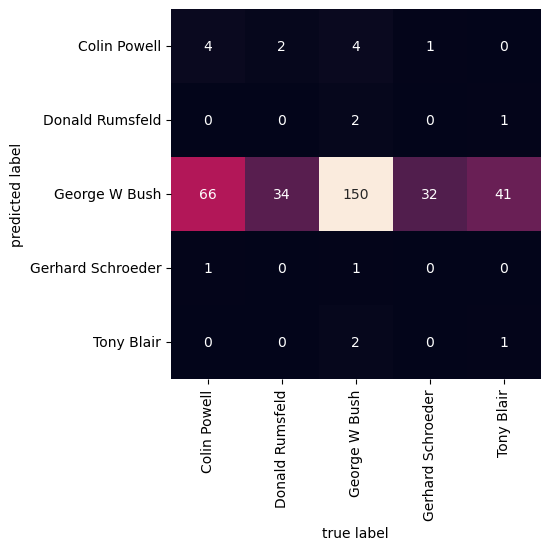

In [11]:
# Eval Confusion Matrix
mat = confusion_matrix(y_test, y_test_predict)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

# Challenge #1 - Random Forest Model with ORB Feature Extraction

## Feature Extraction

In [12]:
# ORB feature extraction
def extract_orb_features(images, max_features=500):
    orb = cv2.ORB_create(nfeatures=max_features)
    orb_features = []
    for image in images:
        keypoints, descriptors = orb.detectAndCompute(image, None)
        if descriptors is None:
            # If ORB doesn't detect enough features, use zeros
            descriptors = np.zeros((max_features, 32))
        # Resize or pad the descriptors to ensure uniform shape
        if descriptors.shape[0] < max_features:
            padding = np.zeros((max_features - descriptors.shape[0], descriptors.shape[1]))
            descriptors = np.vstack((descriptors, padding))
        elif descriptors.shape[0] > max_features:
            descriptors = descriptors[:max_features]
        orb_features.append(descriptors.flatten())
    return np.array(orb_features)

# Extract ORB features from the preprocessed images
orb_features = extract_orb_features(faces_images_processed, max_features=500)
print(f'Extracted ORB Features Shape: {orb_features.shape}')

Extracted ORB Features Shape: (1140, 16000)


## Build Model

In [13]:
from sklearn.metrics import make_scorer

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(orb_features, faces.target, 
                                                    test_size=0.3, random_state=42, 
                                                    stratify=faces.target)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Random Forest Model with Grid Search for Hyperparameter Tuning
rf_model = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20], 
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Use F1 as the scoring metric alongside accuracy
scorer = make_scorer(f1_score, average='weighted')

random_search_rf = RandomizedSearchCV(
    rf_model, param_distributions=param_grid_rf, n_iter=20, 
    scoring=scorer, cv=3, verbose=2, n_jobs=-1, random_state=42
)
random_search_rf.fit(X_train, y_train)

# Best Model from Randomized Search
best_rf_model = random_search_rf.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  17.0s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  17.0s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  17.2s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  17.2s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  17.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  15.5s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  33.1s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time

## Evaluation

Random Forest Accuracy on Train: 46.49%
Random Forest Accuracy on Test: 46.49%
Random Forest F1 Score on Train: 0.30
Random Forest F1 Score on Test: 0.30
                   precision    recall  f1-score   support

     Colin Powell       0.00      0.00      0.00        71
  Donald Rumsfeld       0.00      0.00      0.00        36
    George W Bush       0.46      1.00      0.63       159
Gerhard Schroeder       0.00      0.00      0.00        33
       Tony Blair       0.00      0.00      0.00        43

         accuracy                           0.46       342
        macro avg       0.09      0.20      0.13       342
     weighted avg       0.22      0.46      0.30       342



/home/doni/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/doni/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/doni/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


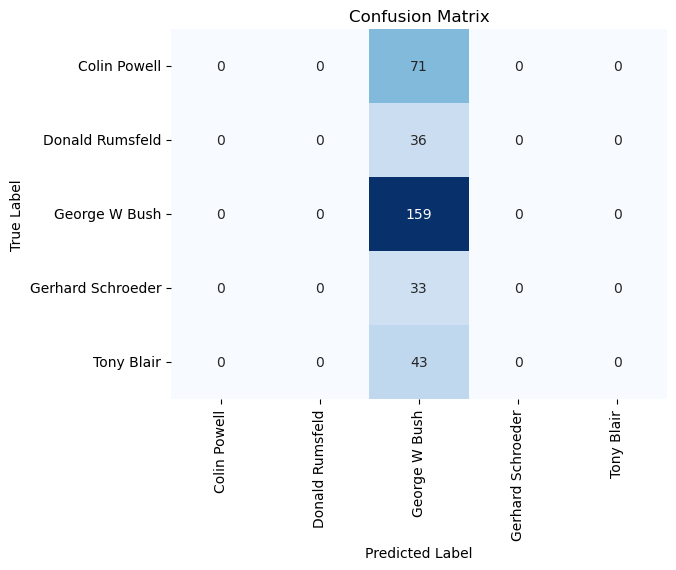

In [14]:
# Evaluation
y_train_predict_rf = best_rf_model.predict(X_train)
y_test_predict_rf = best_rf_model.predict(X_test)

# Print Accuracy and F1 Score
print(f'Random Forest Accuracy on Train: {accuracy_score(y_train, y_train_predict_rf):.2%}')
print(f'Random Forest Accuracy on Test: {accuracy_score(y_test, y_test_predict_rf):.2%}')
print(f'Random Forest F1 Score on Train: {f1_score(y_train, y_train_predict_rf, average="weighted"):.2f}')
print(f'Random Forest F1 Score on Test: {f1_score(y_test, y_test_predict_rf, average="weighted"):.2f}')
print(classification_report(y_test, y_test_predict_rf, target_names=faces.target_names))

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, y_test_predict_rf, faces.target_names)

# Challenge #2 - XGBoost with HOG Feature Extraction

## Extraction

In [15]:
# Function to Extract HOG Features
def extract_hog_features(data):
    hog_features = []
    for image in data:
        # Convert to grayscale
        gray_image = rgb2gray(image)  # Convert to grayscale
        feature = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys')
        hog_features.append(feature)
    return np.array(hog_features)

# Extract HOG features
hog_features = extract_hog_features(faces_images_processed)
print(f'Extracted HOG Features Shape: {hog_features.shape}')

Extracted HOG Features Shape: (1140, 1764)


## Build Model

In [16]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(hog_features, faces.target, 
                                                    test_size=0.3, random_state=42, 
                                                    stratify=faces.target)

# XGBoost Model with Randomized Search for Hyperparameter Tuning
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')

# Define the parameter distribution for Randomized Search
param_dist_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': uniform(0.01, 0.1),  # Randomly sample from a uniform distribution
    'max_depth': randint(3, 10),  # Randomly sample from integers between 3 and 10
    'min_child_weight': randint(1, 6),  # Randomly sample from integers between 1 and 5
}

# Perform Randomized Search
random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_dist_xgb,
                                        n_iter=10, cv=5, verbose=2, n_jobs=-1, random_state=42)
random_search_xgb.fit(X_train, y_train)

# Best Model from Randomized Search
best_model_xgb = random_search_xgb.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END learning_rate=0.047454011884736254, max_depth=7, min_child_weight=3, n_estimators=50; total time= 2.7min
[CV] END learning_rate=0.047454011884736254, max_depth=7, min_child_weight=3, n_estimators=50; total time= 2.7min
[CV] END learning_rate=0.047454011884736254, max_depth=7, min_child_weight=3, n_estimators=50; total time= 2.7min
[CV] END learning_rate=0.047454011884736254, max_depth=7, min_child_weight=3, n_estimators=50; total time= 2.7min
[CV] END learning_rate=0.047454011884736254, max_depth=7, min_child_weight=3, n_estimators=50; total time= 2.8min
[CV] END learning_rate=0.0696850157946487, max_depth=4, min_child_weight=3, n_estimators=200; total time= 3.4min
[CV] END learning_rate=0.0696850157946487, max_depth=4, min_child_weight=3, n_estimators=200; total time= 3.4min
[CV] END learning_rate=0.0696850157946487, max_depth=4, min_child_weight=3, n_estimators=200; total time= 3.5min
[CV] END learning_rate=0.06968

## Evaluation

Accuracy on Train: 100.00%
Accuracy on Test: 84.80%
                   precision    recall  f1-score   support

     Colin Powell       0.90      0.89      0.89        71
  Donald Rumsfeld       1.00      0.58      0.74        36
    George W Bush       0.81      0.98      0.89       159
Gerhard Schroeder       0.90      0.58      0.70        33
       Tony Blair       0.82      0.72      0.77        43

         accuracy                           0.85       342
        macro avg       0.89      0.75      0.80       342
     weighted avg       0.86      0.85      0.84       342



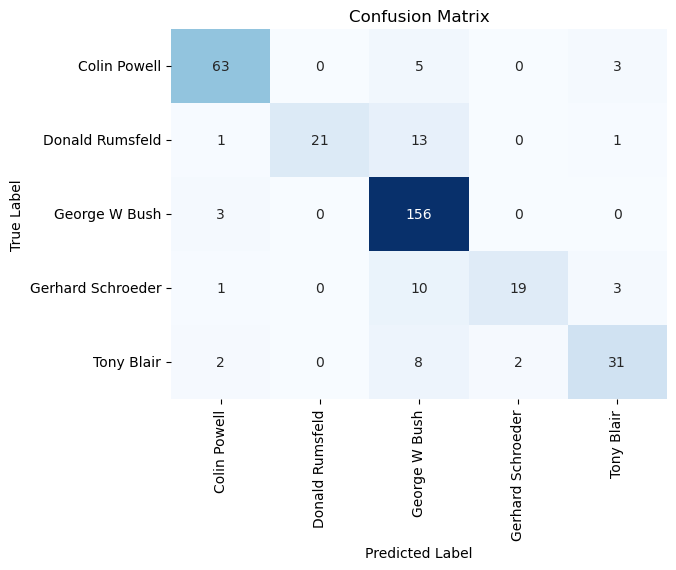

In [19]:
# Evaluation
y_train_predict = best_model_xgb.predict(X_train)
y_test_predict = best_model_xgb.predict(X_test)

# Print Accuracy and Classification Report
print(f'Accuracy on Train: {accuracy_score(y_train, y_train_predict):.2%}')
print(f'Accuracy on Test: {accuracy_score(y_test, y_test_predict):.2%}')
print(classification_report(y_test, y_test_predict, target_names=faces.target_names))

# Plot confusion matrix
plot_confusion_matrix(y_test, y_test_predict, faces.target_names)